In [60]:
import datetime as dt
import numpy as np
import pandas as pd
import json
from types import SimpleNamespace
from hdfs import InsecureClient
import pyrasterframes
from pyrasterframes.rasterfunctions import *
from pyrasterframes.utils import create_rf_spark_session
from pyrasterframes import *
import pyrasterframes.rf_ipython
from IPython.display import display
import os.path
from pyspark.sql.functions import *
from pyspark.sql import Row
from pyspark.sql.window import Window
from shapely.geometry import Point

In [111]:
# Load configuration
with open('/home/bdm/repo/config/config.json', 'r') as f:
    cfg = json.load(f, object_hook=lambda d: SimpleNamespace(**d))

# Setup spark
spark = create_rf_spark_session()

# Setup HDFS client
client = InsecureClient(cfg.hdfs.url, user=cfg.hdfs.user)

In [3]:
# Get most recent timestamp and download key by sorting file paths
occurrences_hdfs = '{}/{}/{}/'.format(
    cfg.hdfs.paths.landing.persistent, 
    cfg.gbif.source,
    cfg.gbif.version
)
occurrences_hdfs += sorted(client.list(occurrences_hdfs))[-1] + '/'
occurrences_hdfs += sorted(client.list(occurrences_hdfs))[-1] + '/occurrence.parquet'

# Get occurrences from persistent landing zone
occurrences = spark.read.parquet(cfg.hdfs.dfs + occurrences_hdfs)

# Get relevant columns
occurrences = occurrences.select("species", "decimallongitude", "decimallatitude", "day", "month", "year")

# Pre-process data for spacial join
occurrences = occurrences.withColumn("geometry", st_point(col("decimallongitude").cast("Double"), col("decimallatitude").cast("Double")))
occurrences = occurrences.withColumnRenamed("decimallongitude", "longitude").withColumnRenamed("decimallatitude", "latitude")

# Extract the 10 most iconic endangered species in the Yucatán Peninsula
# Source: https://www.biologicaldiversity.org/programs/international/mexico/pdfs/English-Top-10-Endangered-Mexico.pdf
occurrences = occurrences.filter(col("species").isin(cfg.swd.species_of_interest))

# Sort occurrences by date
occurrences = occurrences.withColumn("date", concat_ws("-", col("year"), col("month"), col("day")).cast("date"))
occurrences = occurrences.withColumn("date", when(col("date").isNull(), dt.date.today()).otherwise(col("date")))
# occurrences = occurrences.sort('date')

occurrences

species,longitude,latitude,day,month,year,geometry,date
Danaus plexippus,-89.257778,18.591111,24,6,2003,POINT (-89.257778 18.591111),2003-06-24
Danaus plexippus,-87.783333,18.4715,5,11,1990,POINT (-87.783333 18.4715),1990-11-05
Danaus plexippus,-88.809722,19.896667,8,12,1992,POINT (-88.809722 19.896667),1992-12-08
Danaus plexippus,-87.122778,20.580556,16,3,1997,POINT (-87.122778 20.580556),1997-03-16
Danaus plexippus,-89.257778,18.591111,24,6,2003,POINT (-89.257778 18.591111),2003-06-24


In [4]:
# Samples With Data (SWD) format - Join occurrences with most appropriate raster for each feature at each point in time and space.
swd = occurrences

# TODO: Read most appropriate raster data (day-month-year) (parallel scan?)

In [38]:
occurrences


species,longitude,latitude,day,month,year,geometry,date
Danaus plexippus,-89.257778,18.591111,24,6,2003,POINT (-89.257778 18.591111),2003-06-24
Danaus plexippus,-87.783333,18.4715,5,11,1990,POINT (-87.783333 18.4715),1990-11-05
Danaus plexippus,-88.809722,19.896667,8,12,1992,POINT (-88.809722 19.896667),1992-12-08
Danaus plexippus,-87.122778,20.580556,16,3,1997,POINT (-87.122778 20.580556),1997-03-16
Danaus plexippus,-89.257778,18.591111,24,6,2003,POINT (-89.257778 18.591111),2003-06-24


In [6]:
# Background: Given a grid of geolocation points, sample a specific set of rasters with the most current data
# Create a 100 x 100 coordinate grid for background data
background_rows = []
for lat in np.linspace(cfg.swd.extent.min_lat,cfg.swd.extent.max_lat, 100):
    for lon in np.linspace(cfg.swd.extent.min_lon,cfg.swd.extent.max_lon, 100):
        background_rows.append(Row(species='background', longitude=lon.item(), latitude=lat.item(), geometry=Point(lon.item(), lat.item()), date=dt.date.today()))

background = spark.createDataFrame(background_rows)
background

date,geometry,latitude,longitude,species
2022-06-04,POINT (-93 17),17.0,-93.0,background
2022-06-04,POINT (-92.92929292929293 17),17.0,-92.92929292929293,background
2022-06-04,POINT (-92.85858585858585 17),17.0,-92.85858585858585,background
2022-06-04,POINT (-92.78787878787878 17),17.0,-92.78787878787878,background
2022-06-04,POINT (-92.71717171717172 17),17.0,-92.71717171717172,background


In [7]:
# Load current NEO datasets
neo_catalogs = {}

# Date parsers for each dataset
def date_parser(dataset, filename):    
    # Find correct format
    ds = {}
    for d in cfg.neo.datasets:
        if d.name == dataset:
            ds = d
            break
        
    return dt.datetime.strptime(filename.split(".pq")[0], ds.dates.format)


for dataset in cfg.neo.datasets:
    hdfs_path = '{}/{}/{}/'.format(
        cfg.hdfs.paths.landing.persistent, 
        cfg.neo.source,
        dataset.name
    )
    
    # Get most recent load timestamp
    hdfs_path += sorted(client.list(hdfs_path))[-1] + '/'
    
    # Generate catalog for dataset
    neo_catalogs[dataset.name] =  [{
        "path": cfg.hdfs.dfs + hdfs_path + scene,
        "date": date_parser(dataset.name, scene),
        "raster": spark.read.parquet(cfg.hdfs.dfs + hdfs_path + scene)
        } for scene in client.list(hdfs_path)]

neo_catalogs
# TODO: Sample all current rasters in background coordinates (add a new column for each variable)

{'SRTM_RAMP2_TOPO': [{'path': 'hdfs://pikachu.fib.upc.es:27000/user/bdm/persistent/neo/SRTM_RAMP2_TOPO/2022-06-02_11-38-53/2000.pq',
   'date': datetime.datetime(2000, 1, 1, 0, 0),
   'raster': DataFrame[proj_raster_path: string, proj_raster: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>]}],
 'MOD_LSTD_M': [{'path': 'hdfs://pikachu.fib.upc.es:27000/user/bdm/persistent/neo/MOD_LSTD_M/2022-06-02_11-39-47/2000-02.pq',
   'date': datetime.datetime(2000, 2, 1, 0, 0),
   'raster': DataFrame[proj_raster_path: string, proj_raster: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>]},
  {'path': 'hdfs://pikachu.fib.upc.es:27000/user/bdm/persistent/neo/MOD_LSTD_M/2022-06-02_11-39-47/2000-03.pq',
   'date': datetime.datetime(2000, 3, 1, 0, 0),
   'raster': DataFrame[proj_raster_path: string, proj_raster: struct<tile_context:struct<extent:

In [102]:
# Load current WorldClim datasets
worldclim_catalogs = {}

# Date parsers for each variable type
def date_parser(variable, filename):
    today = dt.date.today()
    day = today.day
    month = today.month
    year = today.year
    
    if variable not in ("bio", "elev"):
        month = int(filename.split(".pq")[0])
        
    return dt.date(year, month, day)


# Most recent files with required variables at specified resolution (max)
resolution = cfg.worldclim.resolutions[-1]
variables = cfg.worldclim.variables
for variable in variables:
    hdfs_path = '{}/{}/{}/'.format(
        cfg.hdfs.paths.landing.persistent, 
        cfg.worldclim.source,
        cfg.worldclim.version
    )
    # Get most recent load timestamp
    hdfs_path += '{}/{}/{}/'.format(
        sorted(client.list(hdfs_path))[-1], 
        resolution,
        variable
    )        
    # Generate catalog for dataset
    worldclim_catalogs[variable] = [{
        "path": cfg.hdfs.dfs + hdfs_path + scene,
        "date": date_parser(variable, scene),
        "raster": spark.read.parquet(cfg.hdfs.dfs + hdfs_path + scene)
    } for scene in client.list(hdfs_path) if scene[-3:] == ".pq"]

worldclim_catalogs

{'tmin': [{'path': 'hdfs://pikachu.fib.upc.es:27000/user/bdm/persistent/worldclim/2.1/2022-06-02_11-35-08/30s/tmin/01.pq',
   'date': datetime.date(2022, 1, 4),
   'raster': DataFrame[proj_raster_path: string, proj_raster: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>]},
  {'path': 'hdfs://pikachu.fib.upc.es:27000/user/bdm/persistent/worldclim/2.1/2022-06-02_11-35-08/30s/tmin/02.pq',
   'date': datetime.date(2022, 2, 4),
   'raster': DataFrame[proj_raster_path: string, proj_raster: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:double>,crs:struct<crsProj4:string>>,tile:udt>]},
  {'path': 'hdfs://pikachu.fib.upc.es:27000/user/bdm/persistent/worldclim/2.1/2022-06-02_11-35-08/30s/tmin/03.pq',
   'date': datetime.date(2022, 3, 4),
   'raster': DataFrame[proj_raster_path: string, proj_raster: struct<tile_context:struct<extent:struct<xmin:double,ymin:double,xmax:double,ymax:d

In [83]:
def join_with_raster(df, rf, col_name):
    orig_columns = df.columns

    tmp_df = df.join(rf, st_intersects(
        st_reproject(rf_geometry(col('proj_raster')), rf_crs(col('proj_raster')).crsProj4, rf_mk_crs('EPSG:4326')),
        col('geometry')
    ))

    tmp_df = tmp_df.withColumn("extent", rf_extent(col("proj_raster")))
    tmp_df = tmp_df.withColumn("dims", rf_dimensions(col("proj_raster")))

    calc_col = round((col("extent").xmax - st_x(col('geometry')))/(col("extent").xmax - col("extent").xmin) * col("dims").cols).cast("Integer")
    calc_row = round((col("extent").ymax - st_y(col('geometry')))/(col("extent").ymax - col("extent").ymin) * col("dims").rows).cast("Integer")
    tmp_df = tmp_df.select("*", rf_explode_tiles(col('proj_raster').alias(col_name))).filter(calc_col == col("column_index")).filter(calc_row == col("row_index"))
    return tmp_df.select(*orig_columns, col_name)

var_name = "SRTM_RAMP2_TOPO"
rf = neo_catalogs[var_name][0]["raster"]
df = background
join_with_raster(df, rf, var_name).show()

+----------+--------------------+----------+------------------+
|      date|            geometry|   species|   SRTM_RAMP2_TOPO|
+----------+--------------------+----------+------------------+
|2022-06-04|      POINT (-93 17)|background|           99999.0|
|2022-06-04|POINT (-92.929292...|background|           99999.0|
|2022-06-04|POINT (-92.858585...|background|           99999.0|
|2022-06-04|POINT (-92.787878...|background|           99999.0|
|2022-06-04|POINT (-92.717171...|background|           99999.0|
|2022-06-04|POINT (-92.646464...|background|           99999.0|
|2022-06-04|POINT (-92.575757...|background|           99999.0|
|2022-06-04|POINT (-92.505050...|background| 8.035216331481934|
|2022-06-04|POINT (-92.434343...|background|  83.4273681640625|
|2022-06-04|POINT (-92.363636...|background|  83.4273681640625|
|2022-06-04|POINT (-92.292929...|background|258.01971435546875|
|2022-06-04|POINT (-92.222222...|background|    393.7255859375|
|2022-06-04|POINT (-92.151515...|backgro

date,geometry,species,proj_raster_path,proj_raster
2003-06-24,POINT (-89.257778 18.591111),Danaus plexippus,/tmp/worldclim/2.1/2022-06-02_11-35-08/30s/tmin/wc2.1_30s_tmin_01.tif,
1990-11-05,POINT (-87.783333 18.4715),Danaus plexippus,/tmp/worldclim/2.1/2022-06-02_11-35-08/30s/tmin/wc2.1_30s_tmin_01.tif,
1992-12-08,POINT (-88.809722 19.896667),Danaus plexippus,/tmp/worldclim/2.1/2022-06-02_11-35-08/30s/tmin/wc2.1_30s_tmin_01.tif,
1997-03-16,POINT (-87.122778 20.580556),Danaus plexippus,/tmp/worldclim/2.1/2022-06-02_11-35-08/30s/tmin/wc2.1_30s_tmin_01.tif,
2003-06-24,POINT (-89.257778 18.591111),Danaus plexippus,/tmp/worldclim/2.1/2022-06-02_11-35-08/30s/tmin/wc2.1_30s_tmin_01.tif,

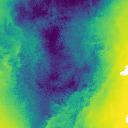
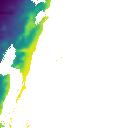
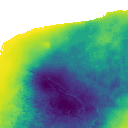
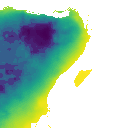
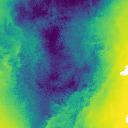

In [105]:
var_name = "bio"
rf = worldclim_catalogs[var_name][0]["raster"]
df = occurrences
df.join(rf, st_intersects(
        st_reproject(rf_geometry(col('proj_raster')), rf_crs(col('proj_raster')).crsProj4, rf_mk_crs('EPSG:4326')),
        col('geometry')
    ))

In [104]:
# Prepare DFs (select only necessary columns)
background = background.select('date', 'geometry', 'species')
occurrences = occurrences.select('date', 'geometry', 'species')
df = occurrences.union(background)

for var_name, rasters in neo_catalogs.items():
    # TODO: Select most appropriate raster to join by date
    # Here we are getting the most recent raster
    rf = sorted(rasters, key=lambda d: d['date'])[-1]["raster"]
    df = join_with_raster(df, rf, var_name)

for var_name, rasters in worldclim_catalogs.items():
    # TODO: Select most appropriate raster to join by date
    # Here we are getting the most recent raster
    rf = sorted(rasters, key=lambda d: d['date'])[-1]["raster"]
    df = join_with_raster(df, rf, var_name)

df.show(200)

+----------+--------------------+----------------+------------------+------------------+------------------+------------------+------------------+----+-------+------------------+------------------+------------------+-----+
|      date|            geometry|         species|   SRTM_RAMP2_TOPO|        MOD_LSTD_M|              tmin|              tmax|              tavg|prec|   srad|              wind|              vapr|               bio| elev|
+----------+--------------------+----------------+------------------+------------------+------------------+------------------+------------------+----+-------+------------------+------------------+------------------+-----+
|2003-06-24|POINT (-89.257778...|Danaus plexippus|               0.0|           99999.0|15.600000381469727|28.200000762939453|21.899999618530273|48.0|13889.0| 1.600000023841858|2.1700000762939453|24.233333587646484|265.0|
|1990-11-05|POINT (-87.783333...|Danaus plexippus|2.4800050258636475|           99999.0|               NaN|     

In [109]:
outdir = cfg.hdfs.dfs + cfg.hdfs.paths.formatted.swd
client.makedirs(outdir)
df.select() \
    .filter() \
    .write.option("header", True).csv(outdir + "/swd.csv")

Py4JJavaError: An error occurred while calling o11210.save.
: java.lang.ClassNotFoundException: org.postgresql.Driver
	at java.net.URLClassLoader.findClass(URLClassLoader.java:382)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:424)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:357)
	at org.apache.spark.sql.execution.datasources.jdbc.DriverRegistry$.register(DriverRegistry.scala:45)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions$$anonfun$5.apply(JDBCOptions.scala:99)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions$$anonfun$5.apply(JDBCOptions.scala:99)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:99)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:197)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:201)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:45)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:45)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:70)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:68)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.doExecute(commands.scala:86)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:80)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:80)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:676)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:676)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:676)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:285)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:271)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
